This notebook implements the machine learning models.


In [1]:
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, balanced_accuracy_score, roc_auc_score, roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt

**Define functions**

In [22]:
def create_labels(df):
    '''
    change the labels, control and IBD, to 0 and 1
    '''
    y = [-1] * len(df)

    for i in range(0, len(df)):
        if df.loc[i][2] == "IBD":
            y[i] = 1
        else:
            y[i] = 0
    return y

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based on the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.legend([f'AUC = {round(roc_auc_score(true_y, y_prob), 2)}'], loc='upper left')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')


def svm_search_params(x, y):
    """
    finds parameters for svm classifier with grid search and returns the best model

    :param x: scaled train data
    :param y: train labels
    :return: SVM classifier with best parameters
    """

    # SVM model
    svc_clf = SVC(kernel='rbf')

    # set up the search grid for parameter values: regularization parameter C and gamma
    param_grid = {'C': [2**j for j in range(-5, 10, 2)], 'gamma': [2**j for j in range(-15, 3, 2)]}

    # perform grid search cross-validation (stratified (target variable) 5-fold) to find the best parameters
    grid_search = GridSearchCV(svc_clf, param_grid, cv=5)
    grid_search.fit(x,y)
    print("Best parameters SVM: ", grid_search.best_params_)
    print("Best score SVM: ", grid_search.best_score_)

    # return best model
    svc_opt = grid_search.best_estimator_

    return svc_opt

def rf_search_params(x, y):
    """
    finds parameters for random forest classifier with grid search and returns the best model

    :param x: scaled train data
    :param y: train labels
    :return: RF classifier with best parameters
    """

    # random forest model
    clf = RandomForestClassifier()

    # set up the search grid for parameter values
    '''param_grid = {'n_estimators': [400, 600, 800], 
                  'max_depth': [20, 30, 40], 
                  'min_samples_leaf': [1],
                  'min_samples_split': [2]}'''
    
    param_grid = {
        'n_estimators': [600,700,800],
        'max_depth': [20,30,40],
        'min_samples_split': [3,4,5],
        'max_features': ['sqrt'],
        'criterion': ['gini'],
        'bootstrap': [True],
        'min_samples_leaf': [1]
    }
    

    # perform grid search cross-validation (stratified (target variable) 5-fold) to find the best parameters
    grid_search = GridSearchCV(clf, param_grid, cv=5)
    grid_search.fit(x,y)
    print("Best parameters Random Forest: ", grid_search.best_params_)
    print("Best score Random Forest: ", grid_search.best_score_)

    # return best model
    rf_opt = grid_search.best_estimator_

    return rf_opt

def lr_search_params(x, y):
    """
    finds parameters for logistic regression classifier with grid search and returns the best model

    :param x: scaled train data
    :param y: train labels
    :return: lr classifier with best parameters
    """

    # logistic regression model
    clf = LogisticRegression(solver='liblinear')

    # set up the search grid for parameter values: regularization parameter C and penalty term
    param_grid = {'C': np.linspace(0.001, 0.5, 30), 
                  'penalty': ['l1', 'l2']}

    # perform grid search cross-validation (stratified (target variable) 5-fold) to find the best parameters
    grid_search = GridSearchCV(clf, param_grid, cv=5)
    grid_search.fit(x,y)
    print("Best parameters Logistic Regression: ", grid_search.best_params_)
    print("Best score Logistic Regression: ", grid_search.best_score_)

    # return best model
    lr_opt = grid_search.best_estimator_

    return lr_opt


**Load data**

In [4]:
# define path to dataset
path = 'data/relative_abundance_NielsenVilaLi.csv'
df = pd.read_csv(path)
df.head(10)

,Unnamed: 0,study_name,study_condition,subject_id,k__Bacteria.p__Bacteroidetes.c__Bacteroidia.o__Bacteroidales.f__Bacteroidaceae.g__Bacteroides.s__Bacteroides_plebeius,k__Bacteria.p__Bacteroidetes.c__Bacteroidia.o__Bacteroidales.f__Bacteroidaceae.g__Bacteroides.s__Bacteroides_caccae,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Ruminococcaceae.g__Faecalibacterium.s__Faecalibacterium_prausnitzii,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Lachnospiraceae.g__Lachnospiraceae_unclassified.s__Eubacterium_rectale,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Ruminococcaceae.g__Ruminococcaceae_unclassified.s__Eubacterium_siraeum,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Ruminococcaceae.g__Ruminococcus.s__Ruminococcus_bicirculans,...,k__Bacteria.p__Firmicutes.c__Tissierellia.o__Tissierellia_unclassified.f__Tissierellia_unclassified.g__Tissierellia_unclassified.s__Bacteroides_coagulans,k__Bacteria.p__Actinobacteria.c__Coriobacteriia.o__Eggerthellales.f__Eggerthellaceae.g__Slackia.s__Slackia_exigua,k__Bacteria.p__Firmicutes.c__Bacilli.o__Lactobacillales.f__Enterococcaceae.g__Enterococcus.s__Enterococcus_casseliflavus,k__Bacteria.p__Firmicutes.c__Negativicutes.o__Veillonellales.f__Veillonellaceae.g__Veillonella.s__Veillonella_seminalis,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Peptostreptococcaceae.g__Clostridioides.s__Clostridioides_difficile,k__Bacteria.p__Firmicutes.c__Bacilli.o__Lactobacillales.f__Lactobacillaceae.g__Lactobacillus.s__Lactobacillus_pentosus,k__Bacteria.p__Firmicutes.c__Tissierellia.o__Tissierellales.f__Peptoniphilaceae.g__Peptoniphilus.s__Peptoniphilus_lacrimalis,k__Bacteria.p__Firmicutes.c__Bacilli.o__Lactobacillales.f__Streptococcaceae.g__Streptococcus.s__Streptococcus_agalactiae,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Ruminococcaceae.g__Gemmiger.s__Gemmiger_sp_An50,k__Bacteria.p__Firmicutes.c__Bacilli.o__Lactobacillales.f__Enterococcaceae.g__Enterococcus.s__Enterococcus_durans
0,0,LiJ_2014,control,MH0290,0.00000,0.00000,4.63364,3.26718,0.15616,0.12213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,LiJ_2014,control,MH0336,0.00000,0.00000,1.20573,1.38979,0.01259,0.08489,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,LiJ_2014,control,MH0340,0.00000,3.25987,2.82635,0.03563,13.49471,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,LiJ_2014,control,NLF002-IE,0.00000,0.00000,8.59539,0.00000,0.00000,0.34296,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,LiJ_2014,control,NLF009-IE,0.00000,1.83114,12.42438,1.78118,0.17359,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5,LiJ_2014,control,NLM009-IE,0.00300,0.00030,3.84071,0.93718,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,6,LiJ_2014,control,NLM025-IE,2.69577,0.73295,8.30463,1.43917,0.00000,0.71147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,7,LiJ_2014,control,NOF002-IE,0.00046,0.00000,2.51783,0.00081,0.00000,0.30936,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,8,LiJ_2014,control,NOF007-IE,0.01132,1.78422,5.89003,0.00704,0.00000,0.24896,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,9,LiJ_2014,control,NOF013-IE,0.00000,0.00000,6.51111,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
# visualize by phylum level

bact = []
firm = []
verru = []
actino = []
prot = []
fuso = []

for col_name in df.columns:

    if 'Bacteroidetes' in col_name:
        bact.append(col_name)

    if 'Firmicutes' in col_name:
        firm.append(col_name)

    if 'Verrucomicrobia' in col_name:
        verru.append(col_name)

    if 'Actinobacteria' in col_name:
        actino.append(col_name)

    if 'Proteobacteria' in col_name:
        prot.append(col_name)

    if 'Fusobacteria' in col_name:
        fuso.append(col_name)


In [63]:
phyla = df.iloc[:,:4]
phyla['Bacteroidetes'] = df[bact].sum(axis=1)
phyla['Firmicutes'] = df[firm].sum(axis=1)
phyla['Verrucomicrobia'] = df[verru].sum(axis=1)
phyla['Actinobacteria'] = df[actino].sum(axis=1)
phyla['Proteobacteria'] = df[prot].sum(axis=1)
phyla['Fusobacteria'] = df[fuso].sum(axis=1)
phyla

,Unnamed: 0,study_name,study_condition,subject_id,Bacteroidetes,Firmicutes,Verrucomicrobia,Actinobacteria,Proteobacteria,Fusobacteria
0,0,LiJ_2014,control,MH0290,36.73024,57.16239,0.00538,5.80268,0.15636,0.00000
1,1,LiJ_2014,control,MH0336,18.18031,48.13646,23.37916,1.06664,8.00949,0.00000
2,2,LiJ_2014,control,MH0340,60.00489,37.41922,1.41807,0.18750,0.63348,0.00000
3,3,LiJ_2014,control,NLF002-IE,58.38556,36.38986,0.00000,0.18771,0.66345,0.05700
4,4,LiJ_2014,control,NLF009-IE,67.91019,27.60953,0.00000,0.17683,3.59110,0.00000
...,...,...,...,...,...,...,...,...,...,...
896,350,VilaAV_2018,IBD,sub_1000IBD00723,2.81088,86.15302,0.00000,8.89059,2.14551,0.00000
897,351,VilaAV_2018,IBD,sub_1000IBD01328,78.90483,16.23674,0.00000,4.18574,0.65339,0.00000
898,352,VilaAV_2018,IBD,sub_1000IBD01329,11.33014,65.45147,0.00000,18.35398,2.35610,0.00000
899,353,VilaAV_2018,IBD,sub_1000IBD01330,1.88919,59.95227,0.00000,32.68373,4.58095,0.00000


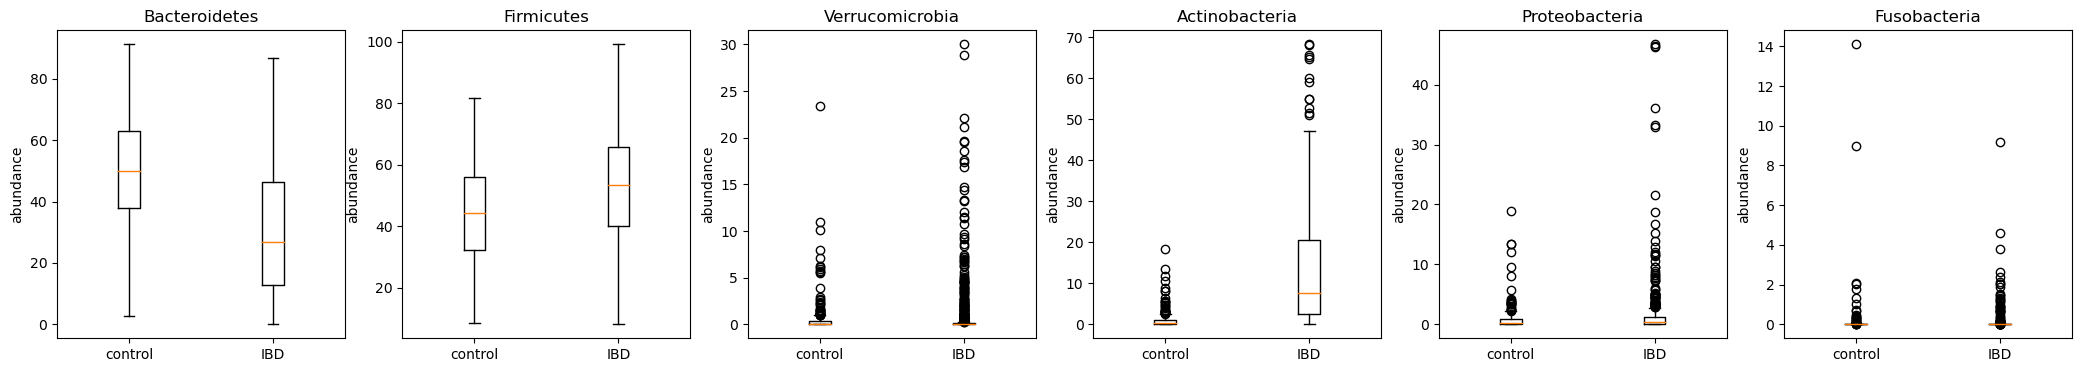

In [83]:

labels = ['control', 'IBD']
fig, ax = plt.subplots(1,6, figsize=(26,4))
for i,p in enumerate(phyla.columns[4:]):
    control = phyla.loc[phyla['study_condition'] == 'control'][p]
    ibd = phyla.loc[phyla['study_condition'] == 'IBD'][p]
    ax[i].boxplot([control,ibd], labels=labels)
    ax[i].set_ylabel("abundance")
    ax[i].set_title(p)

plt.show()

In [6]:
# create y and x
y = np.array(create_labels(df))
x = df.iloc[:, 4:]
print("x shape: ", x.shape, ", y shape: ", y.shape)

# split data to train and test sets
trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# set up scaler
scaler = StandardScaler()

# fit using only train data
scaler.fit(trainX)
trainX = scaler.transform(trainX)
testX = scaler.transform(testX)

print("Train set: IBD => ", np.sum(trainY), ", control => ", trainY.shape[0]-np.sum(trainY))
print("Test set: IBD => ", np.sum(testY), ", control => ", testY.shape[0]-np.sum(testY))

x shape:  (901, 454) , y shape:  (901,)
Train set: IBD =>  514 , control =>  206
Test set: IBD =>  129 , control =>  52


**Classifiers**



In [7]:
# svm
svc = svm_search_params(trainX, trainY)
svc.fit(trainX, trainY)

Best parameters SVM:  {'C': 8, 'gamma': 0.0001220703125}
Best score SVM:  0.898611111111111


SVC(C=8, gamma=0.0001220703125)

In [21]:
# random forest
rf = rf_search_params(trainX, trainY)
rf.fit(trainX, trainY)

Best parameters Random Forest:  {'bootstrap': True, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 800}
Best score Random Forest:  0.9013888888888889


RandomForestClassifier(max_depth=20, min_samples_split=5, n_estimators=800)

In [23]:
# logistic regression
lr = lr_search_params(trainX, trainY)
lr.fit(trainX, trainY)

Best parameters Logistic Regression:  {'C': 0.3107241379310345, 'penalty': 'l1'}
Best score Logistic Regression:  0.8847222222222223


LogisticRegression(C=0.3107241379310345, penalty='l1', solver='liblinear')

In [24]:
# predictions on test set

# svm
y_pred_svc = svc.predict(testX)
balanced_acc_svc = balanced_accuracy_score(testY, y_pred_svc)
print("SVM balanced accuracy on test set: ", balanced_acc_svc)  # average of recall obtained on each class

# random forest
y_pred_rf = rf.predict(testX)
balanced_acc_rf = balanced_accuracy_score(testY, y_pred_rf)
print("Random forest balanced accuracy on test set: ", balanced_acc_rf)

# logistic regression
y_pred_lr = lr.predict(testX)
balanced_acc_lr = balanced_accuracy_score(testY, y_pred_lr)
print("Logistic regression balanced accuracy on test set: ", balanced_acc_lr)

SVM balanced accuracy on test set:  0.8630739415623137
Random forest balanced accuracy on test set:  0.8190220632081098
Logistic regression balanced accuracy on test set:  0.8650864639236733


In [25]:
# print classification reports

print("SVM classification report")
print(classification_report(testY, y_pred_svc, target_names=["healthy", "IBD"]))

print("Random forest classification report")
print(classification_report(testY, y_pred_rf, target_names=["healthy", "IBD"]))

print("Logistic regression classification report")
print(classification_report(testY, y_pred_lr, target_names=["healthy", "IBD"]))


SVM classification report
              precision    recall  f1-score   support

     healthy       0.77      0.83      0.80        52
         IBD       0.93      0.90      0.91       129

    accuracy                           0.88       181
   macro avg       0.85      0.86      0.85       181
weighted avg       0.88      0.88      0.88       181

Random forest classification report
              precision    recall  f1-score   support

     healthy       0.84      0.69      0.76        52
         IBD       0.88      0.95      0.91       129

    accuracy                           0.87       181
   macro avg       0.86      0.82      0.84       181
weighted avg       0.87      0.87      0.87       181

Logistic regression classification report
              precision    recall  f1-score   support

     healthy       0.81      0.81      0.81        52
         IBD       0.92      0.92      0.92       129

    accuracy                           0.89       181
   macro avg       0.87 

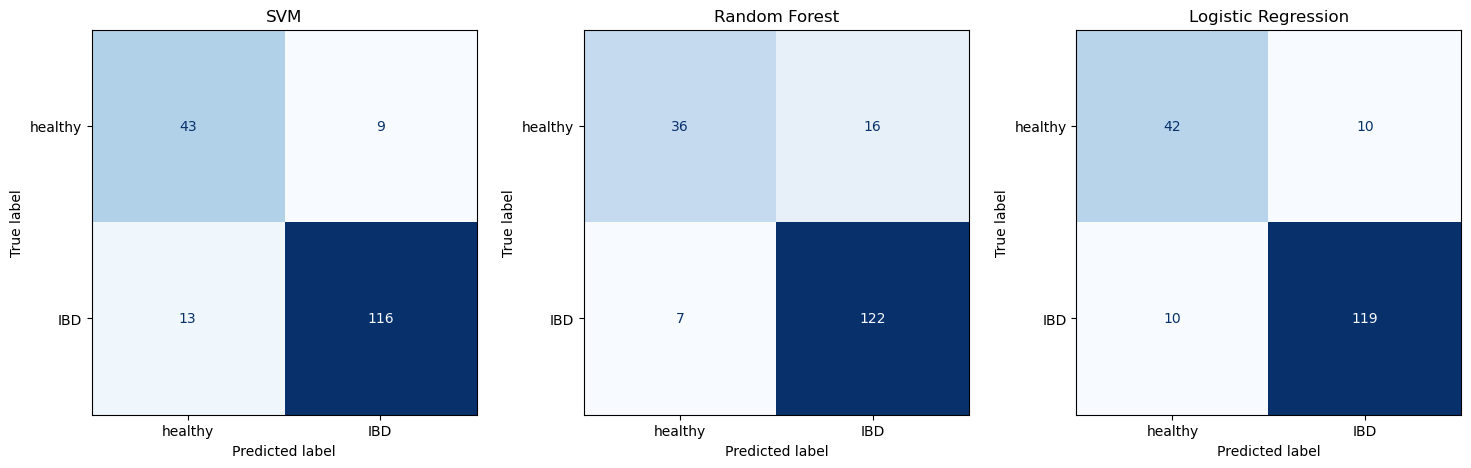

In [33]:
# display confusion matrices

fig, ax = plt.subplots(1,3, figsize=(18,5))

ax[0].set_title("SVM")
ConfusionMatrixDisplay.from_predictions(testY, y_pred_svc, display_labels=["healthy", "IBD"], cmap='Blues', ax=ax[0], colorbar=False)

ax[1].set_title("Random Forest")
ConfusionMatrixDisplay.from_predictions(testY, y_pred_rf, display_labels=["healthy", "IBD"], cmap='Blues', ax=ax[1], colorbar=False)

ax[2].set_title("Logistic Regression")
ConfusionMatrixDisplay.from_predictions(testY, y_pred_lr, display_labels=["healthy", "IBD"], cmap='Blues', ax=ax[2], colorbar=False)

plt.show()

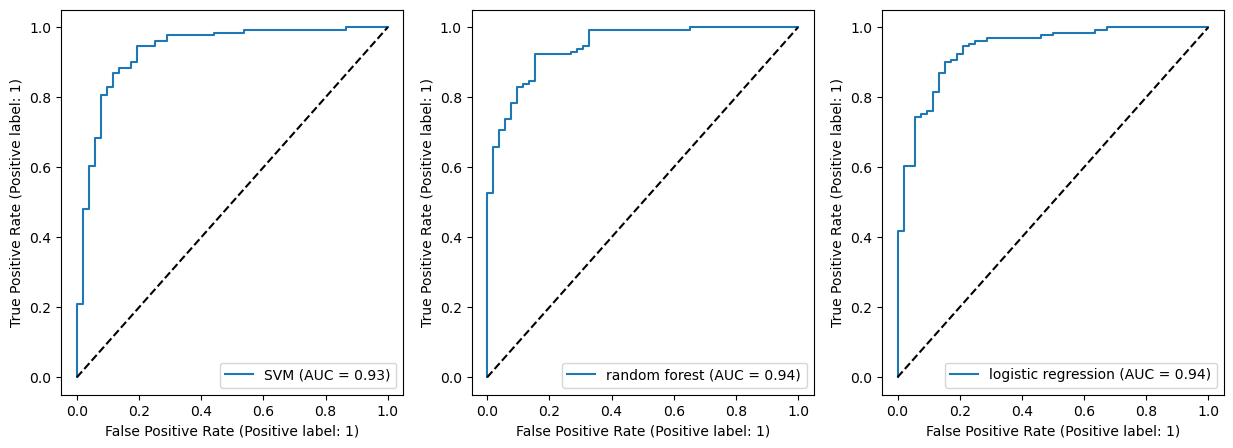

In [80]:
# ROC and AUC
fig, ax = plt.subplots(1,3, figsize=(15,5))

RocCurveDisplay.from_estimator(svc, testX, testY, name="SVM", ax=ax[0])
ax[0].plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

RocCurveDisplay.from_estimator(rf, testX, testY, name="random forest", ax=ax[1])
ax[1].plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

RocCurveDisplay.from_estimator(lr, testX, testY, name="logistic regression", ax=ax[2])
ax[2].plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

plt.show()
